In [1]:
#!/usr/bin/env python
 
import socket
import json
import threading
import time
import numpy as np 
from queue import Queue
from queue import Empty
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import pyaudio
import pdb 

In [2]:
#the data we receive over the netowrk does not neatly aling with the json objects, so je need to search the buffer for valid objects
def dynamic_json_extractor(buffer):
    
    if len(buffer) > 10000:
        #if the buffer has gotten too large (thats over 20 messages) somethin obviously has gone wrong, (mybe something misformatted?) and we should discard this
        print("Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was", len(buffer))
        buffer = ''
    
    timeStamp_ind = buffer.find('timeStamp')
    if timeStamp_ind > -1:
        start = buffer.rfind('{', 0, timeStamp_ind) #find last { before timstamp (json obj starts here)
        if start > -1:
            buffer = buffer[start:]  #discard everything before (cannot be full object anymore)
            #now got through the whole buffer, and see count brackets, until you find the matching closing one
            count = 0
            end_index = 0;
            success = False
            for c in buffer:
                if c == '{':
                    count += 1
                if c == '}':
                    count -= 1
                if count == 0:
                    success = True
                    break;
                end_index += 1
            if success:
                final_json = buffer[:end_index+1]
                buffer = buffer[end_index+1:]
                #print("extracted:", final_json)
                #print("buffer   :", buffer)
                return [buffer, True, final_json]
    return[buffer, False, None]

In [3]:
def recv_sst_data_func(sst_to_processor_queue):
    HOST = ''
    TCP_PORT = 9003
    BUFFER_SIZE = 1024*16 

    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind((HOST, TCP_PORT))
    s.listen(1)

    decoder = json.JSONDecoder()
    buffer = ''
    last_time = time.time()

    #while 1: 
    conn, addr = s.accept()
    print('Connection address pos:', addr)
    while 1:
        data = conn.recv(BUFFER_SIZE)
        if not data: break
        #clear_output()
        #print("received data")
        buffer += data.decode("utf-8")
        #one sst info block are 411 bytes, but sometimes more than one/fragments arrive at once
        #print("buffer len  pre:",len(buffer))

        success = True
        while success: #loop, because sometime more than one packege arrives at once
            [buffer, success, res] = dynamic_json_extractor(buffer)
            if success:
                #print("got smth")
                latest_sound_source_data = json.loads(res)
                #print("elapsed time:", time.time() - last_time)
                last_time = time.time()
                if sst_to_calculator_queue.qsize() > 80: 
                    print("queue has grown to large, discarding some.")
                    for i in range(10): #q is almost full, discard some data
                        try:
                            sst_to_calculator_queue.get(block=False)  
                        except Empty:
                            pass
                sst_to_calculator_queue.put(latest_sound_source_data) #this is blocking and thread safe
                
        #print("buffer len post:",len(buffer))


    conn.close()
    print("closed connection pos")

In [4]:
def angle_processor_sst_thread_func(sst_to_calculator_queue):

    
    #####################visualization
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()
    ax.autoscale(enable=False)
    ax.set_xlim3d(-1.2,1.2)
    ax.set_ylim3d(-1.2,1.2)
    ax.set_zlim3d(-1.2,1.2)
    
    fig.show()
    fig.canvas.draw()
    ###########################

    
    while 1:
        latest_sound_source_data = sst_to_calculator_queue.get(block=True)
        data = []
        for i in range(len(latest_sound_source_data['src'])):
            #{ "id": 53, "tag": "dynamic", "x": -0.828, "y": -0.196, "z": 0.525, "activity": 0.926 }   
            if latest_sound_source_data['src'][i]['id'] > 0:
                data.append([latest_sound_source_data['src'][i]['id'], latest_sound_source_data['src'][i]['x'], latest_sound_source_data['src'][i]['y'], latest_sound_source_data['src'][i]['z'], latest_sound_source_data['src'][i]['activity'] ])
            if len(data) == 0:
                data.append([0,0,0,0,0])

        sources = np.array(data)
    
        #####################visualization
        #visualization is super slow, so only do it, if there is no backlog
        if sst_to_calculator_queue.qsize() < 2:
            ax.clear()
            #add big center point in front
            plotsources = np.vstack((np.array([0, 0, 0, 0, 2]), sources)) #center point
            ax.scatter(plotsources[:,1], plotsources[:,2], plotsources[:,3], s=plotsources[:,4]*150+50, c=plotsources[:,4], cmap=cm.cool)
            for i in range(1, plotsources.shape[0]): #display the assigned id
                ax.text(plotsources[i,1],plotsources[i,2],plotsources[i,3],  '%s, %s' % (str(int(plotsources[i,0])), str(plotsources[i,4])), size=20) 
            ax.set_xlim3d(-1.2,1.2) #dont know why, but otherwise it keeps changin them...
            ax.set_ylim3d(-1.2,1.2)
            ax.set_zlim3d(-1.2,1.2)
            fig.canvas.draw()
        ###########################

In [5]:
def recv_audio_data_thread_func():
    HOST = ''
    TCP_PORT = 9002
    BUFFER_SIZE = 1024*64  

    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind((HOST, TCP_PORT))
    s.listen(1)
    
    list_of_buffs = []
    
    
    ###########audio live streaming
    #this is for live streaming to separated channels
    #we assume we always get a multiple of 512 samples, if not the remainder will be stored in buffers, specific for each thread
    channel_buffer_callback = [np.array([0,0], dtype=np.int16), np.array([0,0], dtype=np.int16), np.array([0,0], dtype=np.int16), np.array([0,0], dtype=np.int16)]
    channel_buffer_feeder = [np.array([0,0], dtype=np.int16), np.array([0,0], dtype=np.int16), np.array([0,0], dtype=np.int16), np.array([0,0], dtype=np.int16)]
    #one queue elemnt will be a 4 elemnt list with np arrays with 512 samples for each of the 4 channels
    feeder_to_callback_queue = Queue(maxsize=1000) 
    
    paud = pyaudio.PyAudio()
    def callback(in_data, frame_count, time_info, status):
        #print("callback getting called")
        #print("len(channel_buffer_callback[0])", len(channel_buffer_callback[0]))
        #print("feeder_to_callback_queue.qsize()", feeder_to_callback_queue.qsize())
        #get all possible data from que and put it into out buffer
        while 1:
            try:
                nextblock = feeder_to_callback_queue.get(block=False)  
                for i in range(4):
                    channel_buffer_callback[i] = np.append(channel_buffer_callback[i], nextblock[i])
            except Empty:
                break
        #if we have enough samples feed them, if not feed 0s
        if len(channel_buffer_callback[0]) >= frame_count:
            out_left = channel_buffer_callback[0][:frame_count]
            out_righ = channel_buffer_callback[1][:frame_count]
            #delete from buffer
            channel_buffer_callback[0] = channel_buffer_callback[0][frame_count:]
            channel_buffer_callback[1] = channel_buffer_callback[1][frame_count:]
        else:
            #print("not enough data, feeding zeros")
            out_left = np.zeros(frame_count, dtype=np.int16)
            out_righ = np.zeros(frame_count, dtype=np.int16)
        #this line interleaves 2 arrays, like this [1,2,3] [1,2,3] becomes [1,1,2,2,3,3]
        #needed, because we have stereo output
        out = np.vstack((out_left,out_righ)).reshape((-1,),order='F') 
        
        data = out.astype(np.int16).tostring()
        return (data, pyaudio.paContinue)
    
    stream = paud.open(format=pyaudio.paInt16,channels=2,rate=16000,output=True,stream_callback=callback)
    ##########################

    conn, addr = s.accept()
    print('Connection address audio:', addr)
    
    first = True
    
    while 1:
        data = conn.recv(BUFFER_SIZE)
        if not data: break
        
        if first:
            stream.start_stream()
            first = False
        
        dataarray = np.frombuffer(data, dtype=np.int16)
        #first put all data into my buffer
        for i in range(4):
            channel_buffer_feeder[i] = np.append(channel_buffer_feeder[i], dataarray[i::4])
        #if my buffer has more than 512 samples feed them into the queue
        while len(channel_buffer_feeder[0]) >= 512:
            #check if there is space in queue, if not clear some
            if feeder_to_callback_queue.qsize() > feeder_to_callback_queue.maxsize-10: 
                    print("feeder queue has grown to large, discarding some.")
                    for i in range(10): #q is almost full, discard some data
                        try:
                            feeder_to_callback_queue.get(block=False)  
                        except queue.Empty:
                            pass
            #we have enough samples, so put list into queue
            feeder_to_callback_queue.put([channel_buffer_feeder[0][:512], channel_buffer_feeder[1][:512], channel_buffer_feeder[2][:512], channel_buffer_feeder[3][:512]])
            #delete them from our buffer
            for i in range(4):
                channel_buffer_feeder[i] = channel_buffer_feeder[i][512:]
                        
            
        #clear_output()
        #print("received data:",  data)
        list_of_buffs.append(np.frombuffer(data, dtype=np.int16))
        #print("got:", list_of_buffs[-1])
        if len(list_of_buffs) > 400:
            break

    conn.close()
    
    stream.stop_stream()
    stream.close()
    paud.terminate()

    print("closed connection audio")
    
    all_audio = np.concatenate(list_of_buffs)
    #print("all_audio.shape", all_audio.shape)
    channels = []
    for i in range(4):
        channels.append(all_audio[i::4])
        #channels[-1] =(channels[-1] - channels[-1].mean()).astype(np.int16) #the channels seem slightly uncentered, so center them

    #print("len chnannels:", len(channels))
    #print("channels[0].shape:", channels[0].shape)
    timemarks = np.array(range(len(channels[0])))
    timemarks = timemarks/16000
    for i in range(len(channels)):
        np.save("ch"+ str(i) + ".npy", channels[i])
    
    #print("timemarks:", timemarks)
    #print("channels[0]:", channels[0])
    f, axarr = plt.subplots(4, sharex=True)
    axarr[0].plot(timemarks, channels[0])
    axarr[1].plot(timemarks, channels[1])
    axarr[2].plot(timemarks, channels[2])
    axarr[3].plot(timemarks, channels[3])
    f.canvas.draw()
        
    

In [6]:
sst_to_calculator_queue = Queue(maxsize=100)

In [7]:
recv_sst_data_thread = threading.Thread(target=recv_sst_data_func, args=(sst_to_calculator_queue, ))
recv_sst_data_thread.start()

In [8]:
angle_processor_sst_thread = threading.Thread(target=angle_processor_sst_thread_func, args=(sst_to_calculator_queue, ))
angle_processor_sst_thread.start()

<IPython.core.display.Javascript object>


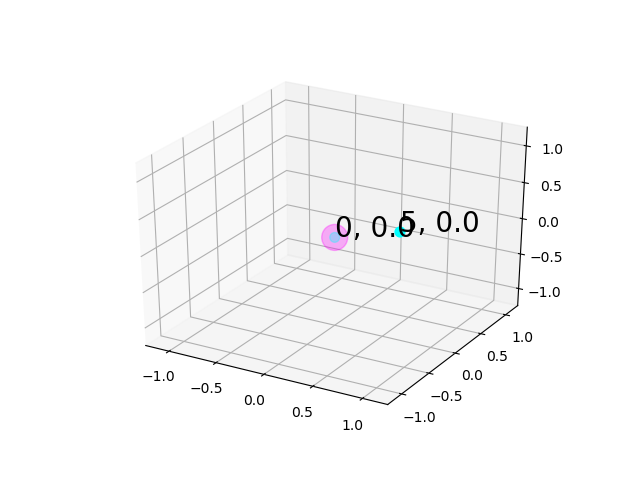

In [9]:
recv_audio_data_thread = threading.Thread(target=recv_audio_data_thread_func)
recv_audio_data_thread.start()

Connection address pos:Connection address audio: ('192.168.178.55', 34954)
 ('192.168.178.55', 33776)
closed connection pos
closed connection audio


<IPython.core.display.Javascript object>


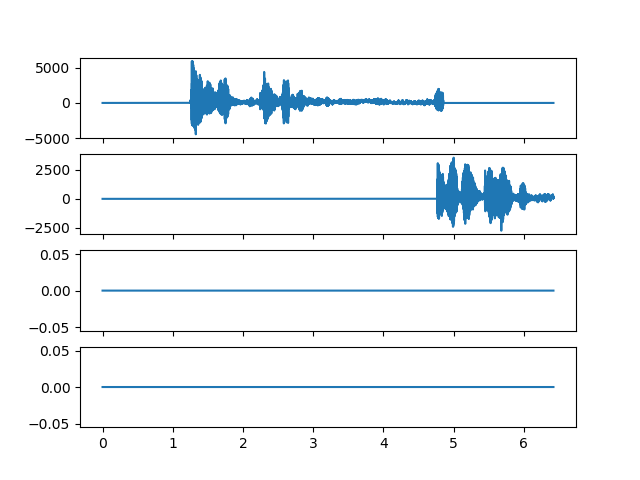

recv_audio_data_thread thread has unexpectly ended (maybe odas stopped running?)
recv_sst_data thread has unexpectly ended (maybe odas stopped running?)


In [ ]:
recv_audio_data_thread.join()#these run for ever, so this will never happen
print("recv_audio_data_thread thread has unexpectly ended (maybe odas stopped running?)")
recv_sst_data_thread.join()#these run for ever, so this will never happen
print("recv_sst_data thread has unexpectly ended (maybe odas stopped running?)")
angle_processor_sst_thread.join()

In [ ]:
channels = []
a = np.array([[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
b = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

c = np.vstack((a,b)).reshape((-1,),order='F')
c

In [ ]:
a[:,1:4]